**Graduation project GAMES - ANALYSIS OF ADVERTISING SOURCES**

**Initial Challenge**: Analyze the behavior of the players depending on the source of the transition. 

We specify the task - we perform it for the marketing department of the company, which plans to display ads in the application. Our ultimate goal is to generate in-app revenue 

**Target**:
- identify the characteristics of players potentially able to bring profit to the company
- optimize user acquisition costs

**Project implementation stages**

**1. Data preprocessing**

**2. Exploratory data analysis taking into account the impact of the source of transition to the game on user behavior**

2.1 Analysis of traffic sources:
- total costs and costs for each attraction channel
- dynamics of advertising costs by channel
- calculation of customer acquisition cost
2.2 Analysis of user behavior in the application as a whole and broken down by traffic sources:
- choice of strategy for passing the first level - the share of users who have passed the first level, the share of users who have passed the first level through the implementation of the project (since these users will see ads in the application).
- the number of buildings on the first level, depending on the chosen strategy for passing the level
- time to complete the first level depending on the chosen strategy
2.3 Calculation of product (application) metrics
- DAU, WAU
- the number of buildings - an analogue of LTV (we earn money when the user sees an ad in our application, that is, when he selects the type of object to build). Further calculation of LTV will be possible when the marketing department determines the cost of one ad view in our application

**3. Statistical hypothesis testing**

3.1. **Hypothesis 1** - The time to complete the level varies depending on the way of passing:
- through the implementation of the project,
- by defeating the first player
        
3.2 **Hypothesis 2** - The number of buildings varies depending on the mode of passage:
- through the implementation of the project,
- by defeating the first player.
        
**4. Conclusions and recommendations**

**Data Description**

The main dataset contains data about events that took place in the Space Brothers mobile game. In it, users build their space program and try to succeed in the difficult task of colonizing the galaxy.

The main monetization of the game is just planned. But it is assumed that the application will display ads on the screen with a choice of the type of object for construction.

The dataset contains data on the game of users at the first level. Completing the first level requires the player to fulfill one of two conditions:

- Defeat the first enemy
- Project implementation - development of an orbital assembly of satellites

The dataset contains the data of the first users of the application - a cohort of users who started using the application from May 4 to May 10 inclusive.

Dataset *game_actions.csv*:

- `event_datetime` — event time;
- `event` is one of three events:
    1. `building` - the object is built,
    2. `finished_stage_1` - the first level is completed,
    3. `project` - the project is completed;
- `building_type` — one of three building types:
    1. `assembly_shop` - assembly shop,
    2. `spaceport` - spaceport,
    3. `research_center` - research center;
- `user_id` - user ID;
- `project_type` - the type of the implemented project;

In addition to the main dataset, there are two datasets with information about advertising activities. They will also help in solving the problem.

Dataset *ad_costs.csv*:

- `day` - the day on which the ad was clicked
- `source` - traffic source
- `cost` - cost of clicks

The user_source.csv dataset contains the following columns:

- `user_id` - user ID
- `source` - sources from which the user who installed the application came

# Reading files and preprocessing data

In [1]:
from urllib.parse import urlencode 
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import timedelta
from scipy import stats as st
sns.set(context='notebook', style='whitegrid', 
        palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc={'figure.figsize':(10,5)})

In [2]:
# checking different paths to csv and opening with separator '\t'
path1 = os.path.join('/datasets', 'game_actions.csv')
path2 = os.path.join('game_actions.csv')
if os.path.exists(path1):
    game_actions = pd.read_csv(path1)
    print(f'path "{path1}" is right')
elif os.path.exists(path2):
    game_actions = pd.read_csv(path2)
    print(f'path "{path2}" is right')
else:
    print('File is not found')
    

path "game_actions.csv" is right


In [3]:
# checking different paths to csv and opening with separator '\t'
path1 = os.path.join('/datasets', 'user_source.csv')
path2 = os.path.join('user_source.csv')
if os.path.exists(path1):
    user_source = pd.read_csv(path1)
    print(f'path "{path1}" is right')
elif os.path.exists(path2):
    user_source = pd.read_csv(path2)
    print(f'path "{path2}" is right')
else:
    print('File is not found')

path "user_source.csv" is right


In [4]:
# checking different paths to csv and opening with separator '\t'
path1 = os.path.join('/datasets', 'ad_costs.csv')
path2 = os.path.join('ad_costs.csv')
if os.path.exists(path1):
    ad_costs = pd.read_csv(path1)
    print(f'path "{path1}" is right')
elif os.path.exists(path2):
    ad_costs = pd.read_csv(path2)
    print(f'path "{path2}" is right')
else:
    print('File is not found')

path "ad_costs.csv" is right


In [5]:
def observe_data(table):
    
    """function to observe data"""
    
    '''Giving common understanding of data in dataframe'''
    print ('Sample')
    display(table.sample(random_state = 10))
    print('_'*100)
    print(f'Rows number: {table.shape[0]} \nColumns number: {table.shape[1]}')
    print('_'*100)
    names_columns = table.columns
    print(f'Columns names: {names_columns}')
    print('_'*100)
    names_to_corrige = []
    for name_column in names_columns:
        if not name_column.islower() or ' ' in name_column:
            names_to_corrige.append(name_column)
    if len(names_to_corrige) == 0:
        print ('Columns names are right')
    else:
        print(f'These names of columns should be corrected: {names_to_corrige}')
    print('_'*100)
    lost_values = table.isna().sum()
    missed_values = lost_values.to_frame(name='missed_values')
    missed_values['percent'] = round(table.isna().mean()*100, 0)
    print ('Missing values:')
    display(missed_values)
    print('_'*100)
    print('Data types:')
    print(table.dtypes)
    print('_'*100)
    print(f'Number of duplicates: {table.duplicated().sum()}', 
          f'percent of duplicates {round(table.duplicated().mean()*100, 0)} %')

## Тable game_actions

In [6]:
observe_data(game_actions)

Sample


,event_datetime,event,building_type,user_id,project_type
51227,2020-05-09 02:11:02,building,spaceport,42c1bdef-8efe-4848-9ffe-d5ea99803078,NaN


____________________________________________________________________________________________________
Rows number: 135640 
Columns number: 5
____________________________________________________________________________________________________
Columns names: Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')
____________________________________________________________________________________________________
Columns names are right
____________________________________________________________________________________________________
Missing values:


,missed_values,percent
event_datetime,0,0.0
event,0,0.0
building_type,7683,6.0
user_id,0,0.0
project_type,133774,99.0


____________________________________________________________________________________________________
Data types:
event_datetime    object
event             object
building_type     object
user_id           object
project_type      object
dtype: object
____________________________________________________________________________________________________
Number of duplicates: 1 percent of duplicates 0.0 %


### Data types

Let's cast the event_datetime column to the datetime type

In [7]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'], format = '%Y-%m-%d %H:%M:%S')

### Duplicates

In [8]:
game_actions[game_actions.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Let's remove this single duplicate

In [9]:
game_actions = game_actions.drop_duplicates()

### Missing values

Let's see what caused missing values in the building_type column. According to the data description, we have an event column with three different events

In [10]:
game_actions.event.unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

We assume that the building type will only be defined for the building event. Let's see if it is

In [11]:
game_actions.query('building_type.isna()')['event'].value_counts()

finished_stage_1    5817
project             1866
Name: event, dtype: int64

Our assumption was confirmed - the gaps in this column are due to the nature of the data and are MNAR - we leave them as they are

The vast majority of values in project_type are also blanks. This column reflects the name of the project for users who completed the project - the development of the orbital assembly of satellites. Apparently, this is the only available project on the first level.

In [12]:
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [13]:
game_actions.query('event == "project" and project_type.isna()')

,event_datetime,event,building_type,user_id,project_type


Our assumption was confirmed - NaNs in this column are due to the peculiarities of the data and are inherent in users who did not complete the project

### Creation of new features

#### Player status

The player can pass the first level only if the project is completed or the first opponent is defeated - for each player we will indicate whether he completed the first level and how

In [14]:
finished_users = game_actions.query('event == "finished_stage_1"')['user_id'].unique()

In [15]:
finished_by_project = game_actions.query('user_id in @finished_users and event == "project"')['user_id'].to_list()

In [16]:
finished_by_fight = game_actions.query('event == "finished_stage_1" and project_type.isna()')['user_id'].to_list()

In [17]:
def get_status(cell):
    if cell in finished_by_project:
        return 'finished_by_project'
    elif cell in finished_by_fight:
        return 'finished_by_fight'
    else: return "in process"

In [18]:
game_actions['status'] = game_actions['user_id'].apply(get_status)

#### Total time in game

In [19]:
time = game_actions.groupby('user_id')['event_datetime'].agg(['max', 'min']).reset_index()
time['days_in_product'] = time['max'].dt.date - time['min'].dt.date
time['days_in_product'] = time['days_in_product'].apply(lambda x: (int(str(x).split(' ')[0])+1))
game_actions = game_actions.merge(time[['user_id', 'days_in_product']], on = 'user_id')

#### Traffic source

In [20]:
game_actions = game_actions.merge(user_source, on = 'user_id')

#### Number of buildings

In [21]:
total_buildings = game_actions.groupby('user_id')['building_type'].count().reset_index().rename(columns = {'building_type':'total_buildings'})

In [22]:
game_actions = game_actions.merge(total_buildings[['user_id', 'total_buildings']], on = 'user_id')

## Table ad_costs

In [23]:
observe_data(ad_costs)

Sample


,source,day,cost
7,instagram_new_adverts,2020-05-03,943.204717


____________________________________________________________________________________________________
Rows number: 28 
Columns number: 3
____________________________________________________________________________________________________
Columns names: Index(['source', 'day', 'cost'], dtype='object')
____________________________________________________________________________________________________
Columns names are right
____________________________________________________________________________________________________
Missing values:


,missed_values,percent
source,0,0.0
day,0,0.0
cost,0,0.0


____________________________________________________________________________________________________
Data types:
source     object
day        object
cost      float64
dtype: object
____________________________________________________________________________________________________
Number of duplicates: 0 percent of duplicates 0.0 %


### Data types

In [24]:
ad_costs.day = pd.to_datetime(ad_costs.day, format = "%Y-%m-%d")

We also take into account that the payment for the advertising campaign took place the day before its launch.

In [25]:
ad_costs.day = ad_costs.day + timedelta(days=1)

## Table user_source

In [26]:
observe_data(user_source)

Sample


,user_id,source
8289,9c39e7f4-55e2-44e2-9e3e-f8fb0990c596,yandex_direct


____________________________________________________________________________________________________
Rows number: 13576 
Columns number: 2
____________________________________________________________________________________________________
Columns names: Index(['user_id', 'source'], dtype='object')
____________________________________________________________________________________________________
Columns names are right
____________________________________________________________________________________________________
Missing values:


,missed_values,percent
user_id,0,0.0
source,0,0.0


____________________________________________________________________________________________________
Data types:
user_id    object
source     object
dtype: object
____________________________________________________________________________________________________
Number of duplicates: 0 percent of duplicates 0.0 %


**Conclusion**

We have prepared data for further research
- removed one single duplicate in the game_actions table
- changed data type for day columns in user_score table and event_datetime columns in game_actions table
- left missing values in the building_type of the game_actions table due to data peculiarities
- created the features necessary for further calculations in game_actions - the time the player interacted with the application, the player's status, the attraction channel, the total number of buildings

# Exploratory data analysis

## Analysis of traffic sources

### Total costs and costs for each channel

In [27]:
print(f'The total cost of attracting users amounted to {round(ad_costs.cost.sum(), 0)} for the period {ad_costs.day.dt.date.min()} - {ad_costs.day.dt.date.max()}')

The total cost of attracting users amounted to 7604.0 for the period 2020-05-04 - 2020-05-10


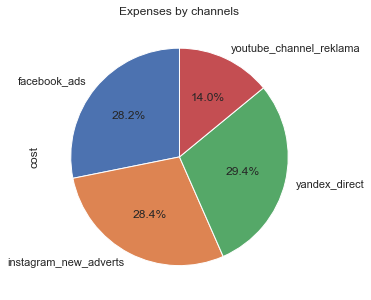

In [28]:
channels_costs = ad_costs.groupby('source')['cost'].sum()
explode=(0.1,0.1,0.1,0.1)
channels_costs.plot.pie(y='cost', figsize=(5, 5), title="Expenses by channels", 
                        legend = False, autopct='%1.1f%%', startangle=90);

### Trends in ad spend by channel

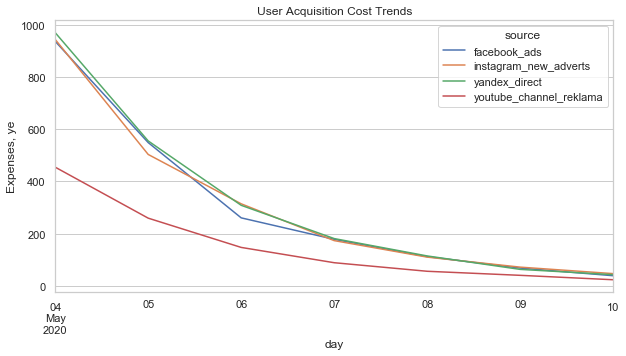

In [29]:
ad_costs.pivot_table(index='day',columns='source',values='cost',aggfunc='sum').plot()
plt.title('User Acquisition Cost Trends')
plt.ylabel('Expenses, уе');

### Calculation of the customer acquisition cost

In [30]:
info_ad = channels_costs.reset_index().merge(user_source.groupby('source')['user_id'].nunique().reset_index(), on = 'source')

In [31]:
info_ad['cac'] = info_ad['cost']/info_ad['user_id']
info_ad = round(info_ad, 2)
info_ad

,source,cost,user_id,cac
0,facebook_ads,2140.90,2726,0.79
1,instagram_new_adverts,2161.44,3347,0.65
2,yandex_direct,2233.11,4817,0.46
3,youtube_channel_reklama,1068.12,2686,0.40


In [32]:
def draw_barplot(data, x, y, title, xlabel, ylabel, hue = None ):
    plot = sns.barplot(data = data, x = x, y = y, hue = hue)
    for p in plot.patches:
        plot.annotate("%.2f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
        xytext=(5, 0), textcoords='offset points', ha="left", va="center")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

In [33]:
def draw_boxplot(data, x, y, title, xlabel, ylabel, hue = None ):
    plot = sns.boxplot(data = data, x = x, y = y, hue = hue)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

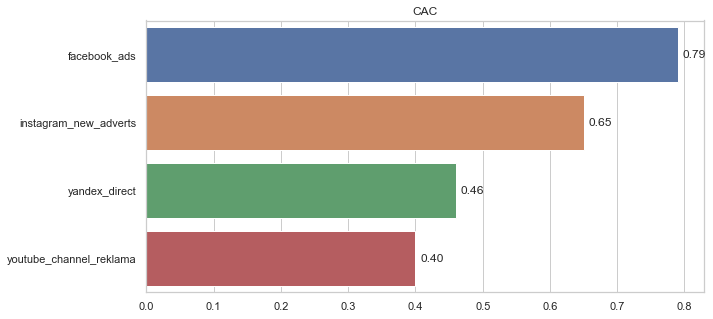

In [34]:
draw_barplot(info_ad, 'cac', 'source', 'CAC', '', '')

**Conclusion**

- costs for 3 channels - yandex_direct, instagram_new_advents, facebook_ads - are distributed almost evenly - about 1/3 of all costs
- on youtube we had a not so large-scale advertising campaign
- advertising campaigns on different platforms lasted the same number of days, namely a week. At the same time, the largest financial costs were observed on the first day.
- the largest number of players came from yandex.direct, the smallest - from youtube_channel_reklama. It is possible that when conducting advertising campaigns, we shared the main focus on attracting Russian users (this is also associated with a small amount of funding for an advertising campaign on youtube)
- in terms of the cost of attracting a user, the lowest CAC is observed for youtube - almost 2 times less than for facebook

**We may slightly revise the budget allocation of our marketing campaigns - increase funding for youtube_channel_reklama - with increased funding and given the same CAC, this campaign can attract more players than similarly funded campaigns on other platforms**

## Analysis of user behavior in the application as a whole and by traffic sources

### Users' choice of strategy for completing the first level

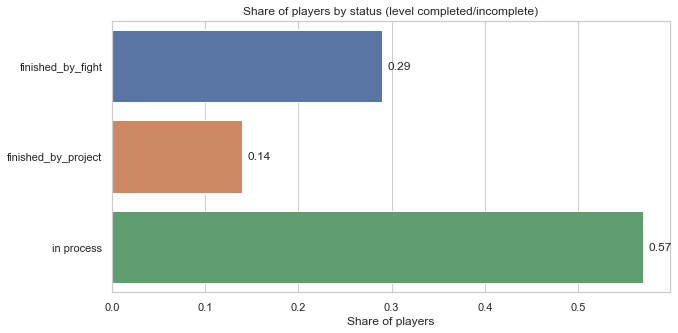

In [35]:
draw_barplot(round((game_actions.groupby('status')['user_id'].nunique()/game_actions.user_id.nunique()).reset_index(), 2),
                    'user_id', 
                     'status', 
                     "Share of players by status (level completed/incomplete)", 
                     "Share of players", 
                     "")

By channels

In [36]:
status_by_traffic = (game_actions.groupby(['status', 'source'])['user_id']
       .nunique()
       .reset_index()
       .merge(user_source.groupby('source')['user_id'].count().reset_index(), on = 'source'))
status_by_traffic['ratio'] = status_by_traffic['user_id_x']/status_by_traffic['user_id_y']

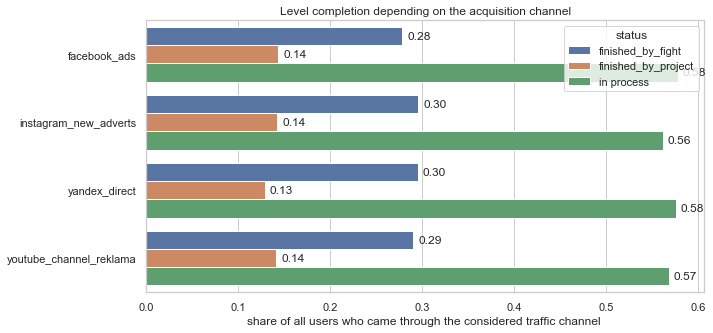

In [37]:
draw_barplot(status_by_traffic, 'ratio', 'source', 
             "Level completion depending on the acquisition channel", 
             "share of all users who came through the considered traffic channel ", "", hue = "status" )

**Conclusion**

- of all users, almost half completed the first level
- users preferred to complete the level by defeating the first opponent - 30% of all players. 15% completed a level by implementing a project
- we cannot say that the player acquisition channel influences the choice of his strategy - in fact, there is no difference in the distribution of players by status for different advertising channels

**More than half of the players have not completed the first level, given that it takes no more than 2 weeks on average to complete this level.  All players came to us through advertising channels between May 4 - 10 and the data was uploaded for the entire month May, then we can assume that the players who did not complete the level simply lost interest in the game and left the application. Players prefer to complete the level with the first victory over the enemy. The user acquisition channel does not affect the choice of the strategy for passing the first level**

### Number of buildings on the first level: depending on the chosen strategy for completing the level

In [38]:
print(f'Total number of buildings: {game_actions.building_type.count()}\nAverage number of building par player: {round(game_actions.building_type.count()/game_actions.user_id.nunique(), 1)}')

Total number of buildings: 127956
Average number of building par player: 9.4


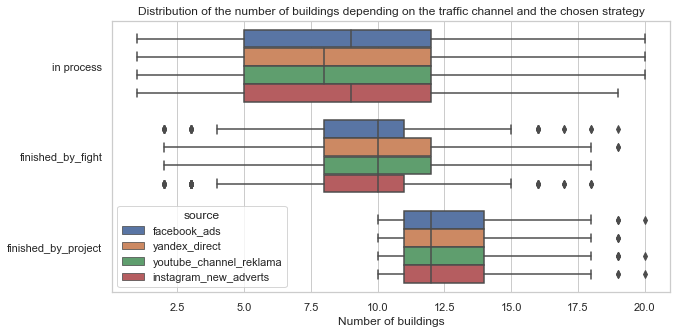

In [39]:
draw_boxplot(game_actions.groupby(['user_id', 'status', 'source'])['building_type'].count().reset_index(), 
             'building_type', 
             'status', 
             "Distribution of the number of buildings depending on the traffic channel and the chosen strategy", 
             "Number of buildings", 
              "", 
              hue = "source" )



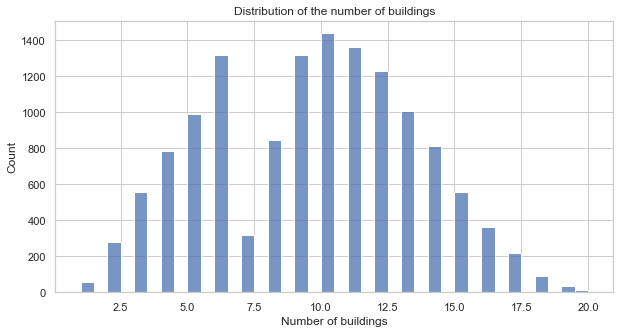

In [40]:
(sns.histplot(data = game_actions.groupby(['user_id', 'source'])['building_type'].count().reset_index(), 
              x = 'building_type'))
plt.title('Distribution of the number of buildings')
plt.xlabel('Number of buildings');

**Conclusion**

- players who complete a level by a project generally have more buildings than players who complete the level by winning.
- we can see that the level can be finished with 2 buildings in case of defeating the enemy
- we made sure once again that the behavior of users does not depend on the channel through which they came
- around 7 buildings there is a sharp decline in the graph of the distribution of the number of buildings - probably most users left the game after 6 buildings - it is necessary to work out this point in more detail and encourage the player to continue the game at this stage

**The user attraction channel does not affect the number of objects built by him in the game, it is beneficial for us that users use the project execution strategy, it is necessary to revise the conditions for passing the first level by winning - some players can complete the level with a minimum number of buildings. Pay special attention to stimulating the continuation of the game after the implementation of the 6th building**

### Dynamics of changes in the number of buildings

In [41]:
game_actions['date'] = game_actions.event_datetime.dt.date

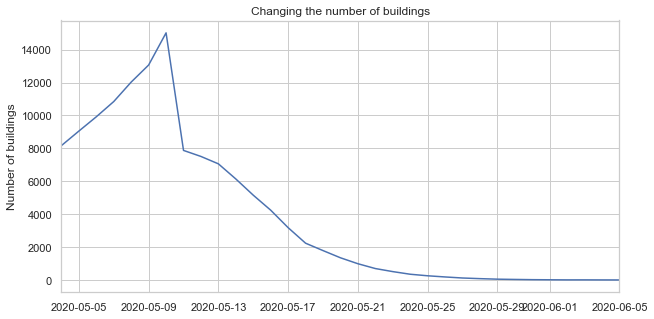

In [42]:
(game_actions.groupby(['date', 'user_id'])['building_type'].count()
             .reset_index().groupby('date')['building_type'].sum().plot())
plt.title('Changing the number of buildings')
plt.xlabel('')
plt.ylabel('Number of buildings');

Consider a similar change in the number of buildings per player

In [43]:
building_by_time = (game_actions.groupby(['date', 'user_id'])['building_type'].count()
                    .reset_index().groupby('date')['building_type'].sum().reset_index()
                    .merge(game_actions.groupby(['date', 'user_id'])['building_type'].count()
                    .reset_index().groupby('date')['user_id'].nunique().reset_index(), on='date'))

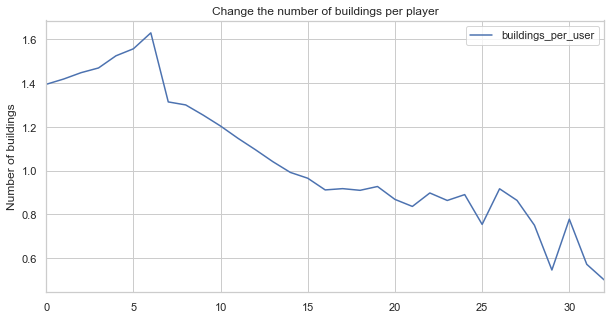

In [44]:
building_by_time['buildings_per_user'] = building_by_time['building_type']/building_by_time['user_id']
building_by_time[['date', 'buildings_per_user']].plot()
plt.title('Change the number of buildings per player')
plt.xlabel('')
plt.ylabel('Number of buildings');

**Conclusion**

- the largest number of buildings is observed in the first 2 weeks from the moment the application is launched, then it decreases due to users leaving the application or completing the first level
- we can see that on average a player produces 1.2-1.6 buildings per day and this indicator decreases starting from the 7th day from the moment the application was launched

**Player activity in terms of building objects decreases after the first week since the launch of the application. It can also be assumed that the quality of users has deteriorated over time - the first users who came built more objects**

### Time to complete the first level depending on the chosen strategy

In [45]:
time = game_actions.groupby('user_id')['event_datetime'].agg(['max', 'min']).reset_index()

In [46]:
time['days_in_product'] = time['max'].dt.date - time['min'].dt.date

In [47]:
time = time.merge(game_actions[['user_id', 'status']], on = 'user_id')

In [48]:
time['days_in_product'] = time['days_in_product'].apply(lambda x: int(str(x).split(' ')[0]))

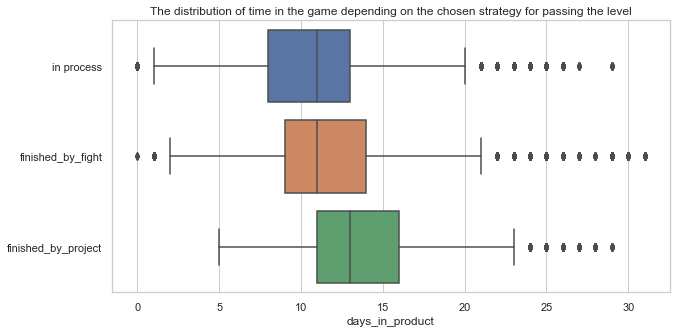

In [49]:
draw_boxplot(time, 
             'days_in_product', 
             'status', 
             "The distribution of time in the game depending on the chosen strategy for passing the level", 
             "days_in_product", 
              "" )



**Conclusion**

- players with projects stay at the first level longer than players who defeated the enemy
- on average, the time to complete the first level is 11-13 days, but there are players who completed it only after a month

**It takes about 11-13 days to complete the first level, you can complete the first level faster by winning the first victory**

# Calculation of product (application) metrics

## DAU, WAU

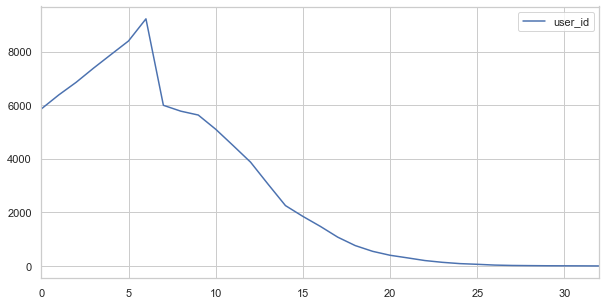

In [50]:
dau = building_by_time[['date', 'user_id']]
dau.plot();

DAU calculation is complicated by the fact that for players who have completed the level, there are no statistics on their further behavior in the application

In [51]:
(game_actions.merge(game_actions.query('status == "finished_by_project" or status == "finished_by_fight"')
                    .groupby('user_id')['event_datetime'].max().reset_index(), 
                    on = ['user_id', 'event_datetime'])['event'].value_counts())

finished_stage_1    5817
Name: event, dtype: int64

Thus, the DAU indicator, as well as the MAU, will be underestimated due to the lack of necessary data

Let's see the date when the players finish the level

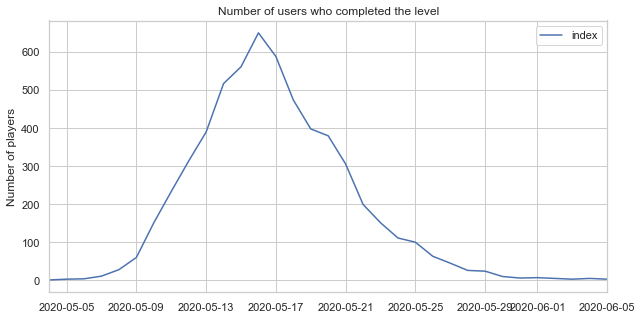

In [52]:
dates_finished = (game_actions.query('status == "finished_by_project" or status == "finished_by_fight"')
                  .groupby('user_id')['event_datetime'].max().reset_index())
dates_finished['event_datetime'].dt.date.reset_index().groupby('event_datetime').count().plot()
plt.title('Number of users who completed the level')
plt.xlabel('')
plt.ylabel('Number of players');


**Conclusion**

**Request full statistics about user behavior in the application for the correct calculation of DAU and MAU - based on the available information, the indicators will be underestimated**

## Number of buildings - analogue of LTV

Let's form a cohort of players by the first date of interaction with the application

In [53]:
first_date_in_app = game_actions.sort_values(by = ['user_id', 'event_datetime']).groupby('user_id')['date'].first().reset_index().rename(columns = {'date':'first_date'})

In [54]:
cohorts = game_actions.merge(first_date_in_app, on = 'user_id')
cohorts['lifetime'] = (cohorts['date'] - cohorts['first_date']).dt.days
cohorts = cohorts.pivot_table(index = 'first_date', columns = 'lifetime', values = 'building_type', aggfunc = 'count')

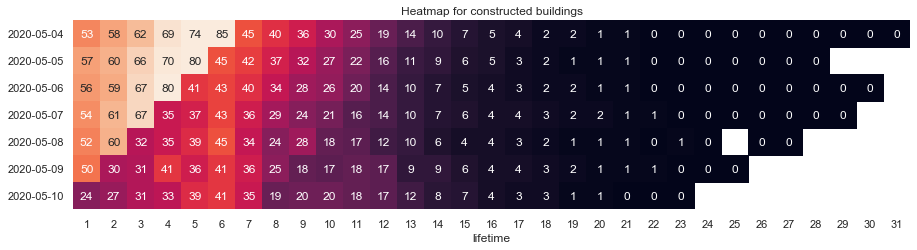

In [55]:
plt.figure(figsize=(15, 6))
sns.heatmap(round(cohorts.div(cohorts[0], axis = 0)*100, 0).drop(0, axis =1),
             annot=True,robust=True,square=True,cbar=0)
plt.title('Heatmap for constructed buildings')
plt.ylabel('');

**Conclusion**

- the behavior of users of different cohorts is similar - after two weeks in the game, users practically do not build anything
- the largest number of buildings is observed on the first day in the game, on the second day it decreases and grows up to 6-7 days, then the number of buildings decreases day by day

# Testing hypotheses

## Hypothesis 1 - The time to complete the level differs depending on the strategy

H0: The average time to complete a level through project implementation is equal to the average time to complete a level after defeating the first opponent

H1: they are not equal

We will choose the level of statistical significance of 0.5, since such accuracy is enough for marketing research

In [56]:
alpha = .05 
time_project = time.query('status == "finished_by_project"')['days_in_product']
time_fight = time.query('status == "finished_by_fight"')['days_in_product']

In [57]:
results = st.ttest_ind(
    time_project, 
    time_fight)

print(f'Average time to complete a level by implementing a project: {round(time_project.mean(), 1)} days')
print(f'Average time to complete a level by defeating an opponent: {round(time_fight.mean(), 1)} days')

print(f'p-value: {results.pvalue}')

if (results.pvalue < alpha):
    print("We reject the null hypothesis - the time to complete the level depends on the strategy")
else:
    print("It is not possible to reject the null hypothesis - the time to complete the level does not depend on the strategy")

Average time to complete a level by implementing a project: 13.4 days
Average time to complete a level by defeating an opponent: 11.6 days
p-value: 0.0
We reject the null hypothesis - the time to complete the level depends on the strategy


## Hypothesis 2 - The number of buildings varies depending on the strategy

H0: The average number of buildings for players who completed the level through the implementation of the project is equal to the average number of buildings for players who completed the level after defeating the first opponent

H1: they are not equal

We will choose the level of statistical significance of 0.5, since such accuracy is enough for marketing research

In [58]:
alpha = .05 
buildings = game_actions.groupby(['user_id', 'status'])['building_type'].count().reset_index()
buildings_project = buildings.query('status == "finished_by_project"')['building_type']
buildings_fight = buildings.query('status == "finished_by_fight"')['building_type']
results = st.ttest_ind(
    buildings_project, 
    buildings_fight)

print(f'Average number of buildings for project implementation: {round(buildings_project.mean(), 1)}')
print(f'Average number of buildings to defeat the enemy: {round(buildings_fight.mean(), 1)}')

print(f'p-value: {results.pvalue}')

if (results.pvalue < alpha):
    print("We reject the null hypothesis - the number of buildings depends on the strategy")
else:
    print("It is not possible to reject the null hypothesis - the number of buildings does not depend on the strategy")

Average number of buildings for project implementation: 12.6
The average number of buildings to defeat the enemy: 9.4
p-value: 0.0
We reject the null hypothesis - the number of buildings depends on the strategy


# Conclusions and recommendations

1. **Hypothesis 1 confirmed** - the time to complete the level varies depending on the strategy: 13.4 days for the implementation of the project and 11.6 days for defeating the first enemy
2. **Hypothesis 2 confirmed** - the number of buildings varies depending on the strategy - 12.6 for project implementation and 9.4 for winning
3. We may slightly revise the budget allocation of our marketing campaigns - increase funding for **youtube_channel_reklama - this campaign can attract more players than similarly funded campaigns on other platforms**
4. **Acquisition channels do not affect user behavior in the game**
5. Players prefer to complete the level with the first victory over the enemy.
6. **It is beneficial for us that users use the project execution strategy, it is necessary to revise the conditions for passing the first level by winning - such players can complete the level with a minimum number of buildings. Pay special attention to stimulating the continuation of the game after the implementation of the 6th building**
7. Player activity in terms of building objects decreases after the first week since the launch of the application
8. It takes about 11-13 days to complete the first level, you can complete the first level more quickly by winning the first victory
9. Request full statistics about user behavior in the application for the correct calculation of DAU and MAU - based on the available information, the indicators will be underestimated